# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: Krystal Hong


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [17]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow.keras
### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [18]:
def to_one_hot(y, num_class=10):
    new_y = []
    for i in y:
        vec = np.zeros(num_class)
        vec[i] = 1
        new_y.append(vec)
    return np.asarray(new_y)

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [19]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train_vec,test_size=0.2)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [20]:
# Build the model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models

model = models.Sequential()
#1 conv, relu, max pool
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

#2 conv, relu, max pool
model.add(Conv2D(64, (4, 4), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
#Dense layers
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_14 (Dense)            (None, 256)              

In [21]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])


In [22]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr, batch_size=100, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
400/400 [==============================] - 3s 6ms/step - loss: 3.7334 - acc: 0.3064 - val_loss: 1.7417 - val_acc: 0.4055
Epoch 2/50
400/400 [==============================] - 2s 5ms/step - loss: 1.5154 - acc: 0.4736 - val_loss: 1.4482 - val_acc: 0.4950
Epoch 3/50
400/400 [==============================] - 2s 5ms/step - loss: 1.2760 - acc: 0.5577 - val_loss: 1.3819 - val_acc: 0.5254
Epoch 4/50
400/400 [==============================] - 2s 6ms/step - loss: 1.1137 - acc: 0.6150 - val_loss: 1.3419 - val_acc: 0.5504
Epoch 5/50
400/400 [==============================] - 2s 6ms/step - loss: 0.9793 - acc: 0.6610 - val_loss: 1.2842 - val_acc: 0.5703
Epoch 6/50
400/400 [==============================] - 2s 5ms/step - loss: 0.8679 - acc: 0.7026 - val_loss: 1.2650 - val_acc: 0.5813
Epoch 7/50
400/400 [==============================] - 2s 5ms/step - loss: 0.7694 - acc: 0.7369 - val_loss: 1.2917 - val_acc: 0.5796
Epoch 8/50
400/400 [==============================] - 2s 5ms/step - loss: 0.

## 3. Plot the training and validation loss curve versus epochs. (5 points)

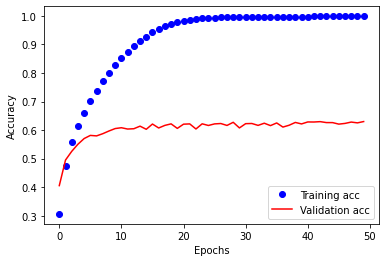

In [25]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(50)
train_acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, valid_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [26]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

model2 = models.Sequential()
#1 conv, relu, max pool
model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))
model2.add(MaxPooling2D((2, 2)))

#2 conv, relu, max pool
model2.add(Conv2D(64, (4, 4), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
#Dense layers
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(10, activation = 'softmax'))

#Optimizer
model2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])


In [27]:
#<Train your model on the entire training set (50K samples)>
history = model2.fit(x_train, y_train_vec, batch_size=100, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
500/500 [==============================] - 4s 5ms/step - loss: 3.6264 - acc: 0.3047 - val_loss: 1.5392 - val_acc: 0.4524
Epoch 2/50
500/500 [==============================] - 2s 5ms/step - loss: 1.4360 - acc: 0.4948 - val_loss: 1.3603 - val_acc: 0.5308
Epoch 3/50
500/500 [==============================] - 2s 5ms/step - loss: 1.2069 - acc: 0.5819 - val_loss: 1.0443 - val_acc: 0.6354
Epoch 4/50
500/500 [==============================] - 3s 5ms/step - loss: 1.0567 - acc: 0.6352 - val_loss: 0.9168 - val_acc: 0.6873
Epoch 5/50
500/500 [==============================] - 3s 5ms/step - loss: 0.9350 - acc: 0.6782 - val_loss: 0.7992 - val_acc: 0.7331
Epoch 6/50
500/500 [==============================] - 2s 5ms/step - loss: 0.8265 - acc: 0.7176 - val_loss: 0.7469 - val_acc: 0.7486
Epoch 7/50
500/500 [==============================] - 2s 5ms/step - loss: 0.7320 - acc: 0.7490 - val_loss: 0.6669 - val_acc: 0.7748
Epoch 8/50
500/500 [==============================] - 2s 5ms/step - loss: 0.

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [28]:
# Evaluate your model performance (testing accuracy) on testing data.

loss_and_acc = model2.evaluate(x_test, y_test_vec)
print("loss = " + str(loss_and_acc[0]))
print("accuracy = " + str(loss_and_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 3.1781 - acc: 0.6475
loss = 3.1781058311462402
accuracy = 0.6474999785423279


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

Epoch 1/50
500/500 [==============================] - 5s 7ms/step - loss: 1.5044 - acc: 0.4669 - val_loss: 1.2979 - val_acc: 0.5399
Epoch 2/50
500/500 [==============================] - 3s 6ms/step - loss: 1.1582 - acc: 0.5931 - val_loss: 1.0864 - val_acc: 0.6145
Epoch 3/50
500/500 [==============================] - 3s 6ms/step - loss: 1.0154 - acc: 0.6469 - val_loss: 0.9799 - val_acc: 0.6590
Epoch 4/50
500/500 [==============================] - 3s 7ms/step - loss: 0.9152 - acc: 0.6819 - val_loss: 0.8502 - val_acc: 0.7057
Epoch 5/50
500/500 [==============================] - 3s 6ms/step - loss: 0.8421 - acc: 0.7075 - val_loss: 0.8143 - val_acc: 0.7183
Epoch 6/50
500/500 [==============================] - 3s 6ms/step - loss: 0.7812 - acc: 0.7290 - val_loss: 0.7492 - val_acc: 0.7388
Epoch 7/50
500/500 [==============================] - 3s 7ms/step - loss: 0.7266 - acc: 0.7500 - val_loss: 0.6666 - val_acc: 0.7701
Epoch 8/50
500/500 [==============================] - 3s 6ms/step - loss: 0.

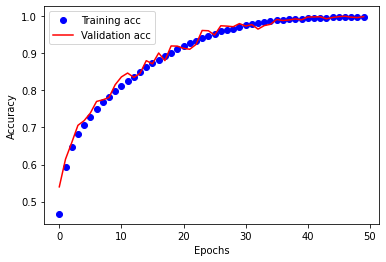

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
#BATCH NORMALIZATION
model3 = models.Sequential()
#1 conv, BN relu, max pool
model3.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

#2 conv, BN, relu, max pool
model3.add(Conv2D(64, (4, 4)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())



#Dense layers
model3.add(Dense(256, activation = 'relu'))
model3.add(Dense(10, activation = 'softmax'))

#Optimizer
model3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])


#Train
history = model3.fit(x_train, y_train_vec, batch_size=100, epochs=50, validation_data=(x_val, y_val))

# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model3.evaluate(x_test, y_test_vec)
print("loss = " + str(loss_and_acc[0]))
print("accuracy = " + str(loss_and_acc[1]))

# Plot the loss curve
%matplotlib inline

epochs = range(50)
train_acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, valid_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Epoch 1/50
500/500 [==============================] - 34s 64ms/step - loss: 1.7362 - acc: 0.3847 - val_loss: 1.5392 - val_acc: 0.4696
Epoch 2/50
500/500 [==============================] - 31s 62ms/step - loss: 1.5390 - acc: 0.4693 - val_loss: 1.4204 - val_acc: 0.5104
Epoch 3/50
500/500 [==============================] - 31s 62ms/step - loss: 1.4555 - acc: 0.5064 - val_loss: 1.3048 - val_acc: 0.5620
Epoch 4/50
500/500 [==============================] - 31s 61ms/step - loss: 1.4027 - acc: 0.5295 - val_loss: 1.2875 - val_acc: 0.5510
Epoch 5/50
500/500 [==============================] - 32s 65ms/step - loss: 1.3559 - acc: 0.5446 - val_loss: 1.2208 - val_acc: 0.5928
Epoch 6/50
500/500 [==============================] - 30s 60ms/step - loss: 1.3224 - acc: 0.5570 - val_loss: 1.2141 - val_acc: 0.5865
Epoch 7/50
500/500 [==============================] - 31s 63ms/step - loss: 1.2901 - acc: 0.5682 - val_loss: 1.1516 - val_acc: 0.6064
Epoch 8/50
500/500 [==============================] - 30s 60ms

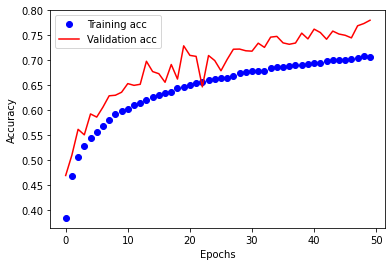

In [30]:
#BATCH NORMALIZATION AND DATA AUGMENTATION

model4 = models.Sequential()
#1 conv, BN, relu, max pool
model4.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D((2, 2)))

#2 conv, BN, relu, max pool
model4.add(Conv2D(64, (4, 4)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Flatten())


#Dense layers
model4.add(Dense(256))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dense(10))
model4.add(BatchNormalization())
model4.add(Activation('softmax'))


#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range = 0.2, shear_range = 0.2, horizontal_flip=True)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size=100)

#Optimizer
model4.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['acc'])


#Train
history = model4.fit(train_generator, steps_per_epoch=len(x_train)/100, epochs=50, validation_data=(x_val, y_val))

# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model4.evaluate(x_test, y_test_vec)
print("loss = " + str(loss_and_acc[0]))
print("accuracy = " + str(loss_and_acc[1]))


# Plot the loss curve
%matplotlib inline

epochs = range(50)
train_acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, valid_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [30]:
# First model accuracy: 0.647
# Model with Batch Normalization: 0.712
# Model with Batch Normalization and Data Augmentation: 0.749